In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from scipy import misc
from matplotlib import pyplot, cm
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
# Array functions

def print_size(array):
    """Print shape, data type and size in GiB of an array."""
    print(array.shape, array.dtype, '| total size:', array.nbytes/2**30, 'GiB')

def compute_coordinates(res, pitch):
    """Return an array of shape (res) containing the coordinates of a sampling lattice centered at zero with given pitch."""
    indices = np.arange(res, dtype=np.float32)
    return (indices - res/2 + 0.5) * pitch

def compute_indices(x, res, pitch):
    """Return indices for given coordinates with respect to given resolution and pitch."""
    return np.floor(x / pitch + res/2).astype(np.int32)

def display_image(values, normalize=True, color_map=None):
    """Display an array of values as an image using a color map."""
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))



# Circle functions

def semicircle(x):
    """Return the positive y coordinate associated to an x coordinate in a unit circle."""
    return cp.sqrt(1.0 - cp.square(x))

def semicircle_integral(x):
    """Return the indefinite integral at x of the semicircle function."""
    return (cp.sqrt(1.0 - cp.square(x)) * x + cp.arcsin(x))/2

def circle_box_area(x_interval, y_interval):
    """Return the area of the intersection of a box against the unit circle."""
    # Positive semicircle medial
    y_clipped = cp.clip(y_interval[..., 0], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area = x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)

    # Positive semicircle lateral
    y_clipped = cp.clip(y_interval[..., 1], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area += x_clipped * y_clipped - semicircle_integral(x_clipped)

    # Negative semicircle medial
    y_clipped = cp.clip(-y_interval[..., 1], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area += x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)

    # Negative semicircle lateral
    y_clipped = cp.clip(-y_interval[..., 0], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area += x_clipped * y_clipped - semicircle_integral(x_clipped)

    return area



# Light field functions

def ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f):
    """Return the coordinates on the retina corresponding to the given coordinates on planes A and B."""
    return (x_a * (1.0 - z_b/z_f) - x_b * (1.0 - z_a/z_f)) * (z_r / (z_a - z_b))

def take_2d(values, idx_x, idx_y):
    """Return values at given indices. Out of bounds are filled with 0."""
    clipped_idx_x = np.clip(idx_x, -1, values.shape[0]) + 1
    clipped_idx_y = np.clip(idx_y, -1, values.shape[1]) + 1
    return np.pad(values, 1, mode='constant')[clipped_idx_x, clipped_idx_y]

def sample_2d_scene(scene_image, res_r, res_a, res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f):
    # Compute coordinates
    x_a = compute_coordinates(res_a, size_a / res_a)[:, np.newaxis]
    x_b = compute_coordinates(res_b, size_b / res_b)[np.newaxis, :]
    # Project display samples to the retina plane
    x_r_over_ab = ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f)
    # Compute corresponding indices on the retina
    idx_r_over_ab = compute_indices(x_r_over_ab, res_r, size_r / res_r)
    # Sample scene
    signal_ab = take_2d(scene_image, idx_r_over_ab[:, np.newaxis, :, np.newaxis], idx_r_over_ab[np.newaxis, :, np.newaxis, :])
    return signal_ab

def square_aperture(x_interval, y_interval, pupil_diameter):
    x_interval = cp.clip(x_interval * 2 / pupil_diameter, -1, 1)
    y_interval = cp.clip(y_interval * 2 / pupil_diameter, -1, 1)
    return cp.subtract(x_interval[..., 1], x_interval[..., 0]) * cp.subtract(y_interval[..., 1], y_interval[..., 0])

def round_aperture(x_interval, y_interval, pupil_diameter):
    return circle_box_area(x_interval * 2 / pupil_diameter, y_interval * 2 / pupil_diameter)

def compute_retinal_image(signal_ab, res_r, res_a, res_b, size_r, size_a, size_b, w_a_ratio, w_b_ratio, z_r, z_a, z_b, z_f, pupil_diameter, aperture):
    # Compute coordinates
    x_r = compute_coordinates(res_r, size_r / res_r)[:, np.newaxis, np.newaxis]
    x_a = compute_coordinates(res_a, size_a / res_a)[np.newaxis, :, np.newaxis]
    x_b = compute_coordinates(res_b, size_b / res_b)[np.newaxis, np.newaxis, :]
    # Project display samples to the pupil plane
    x_a_at_p = (x_a - x_r * (z_a/z_r)) * np.reciprocal(1.0 - z_a/z_f)
    x_b_at_p = (x_b - x_r * (z_b/z_r)) * np.reciprocal(1.0 - z_b/z_f)
    # Project display element sizes to the pupil plane
    w_a_at_p = np.abs(w_a_ratio * (size_a / res_a) * np.reciprocal(1.0 - z_a/z_f))
    w_b_at_p = np.abs(w_b_ratio * (size_b / res_b) * np.reciprocal(1.0 - z_b/z_f))
    # Compute lower and upper bounds of projected display elements
    lower_bounds = np.clip(x_a_at_p - w_a_at_p/2, x_b_at_p - w_b_at_p/2, x_b_at_p + w_b_at_p/2)
    upper_bounds = np.clip(x_a_at_p + w_a_at_p/2, x_b_at_p - w_b_at_p/2, x_b_at_p + w_b_at_p/2)
    # Stack array as [..., 2] where the last dimension is lower|upper bounds and scale to pupil
    pupil_intervals = np.stack((lower_bounds, upper_bounds), axis=-1)
    # Move to GPU
    pupil_intervals = cp.asarray(pupil_intervals)
    signal_ab = cp.asarray(signal_ab)
    # Create an empty retinal image
    retinal_image = np.empty((res_r, res_r))
    # For each retina sample...
    for idx_r in tqdm(np.ndindex((res_r, res_r)), total=res_r**2, leave=False):
        x_intervals = pupil_intervals[idx_r[0]][:, np.newaxis, :, np.newaxis, :]
        y_intervals = pupil_intervals[idx_r[1]][np.newaxis, :, np.newaxis, :, :]
        imaging_tensor = aperture(x_intervals, y_intervals, pupil_diameter)
        retinal_image[idx_r] = cp.sum(imaging_tensor * signal_ab)
    return retinal_image

def decimate_lf(signal_ab, factor):
    """Return the light field decimated by the given factor."""
    return signal_ab[factor//2::factor, factor//2::factor, factor//2::factor, factor//2::factor]

In [3]:
z_r = -17.0
z_a = 10.0
z_b = 30.0

z_f = 1000.0

pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / abs(z_r) + pupil_diameter
size_b = size_r * z_b / abs(z_r) + pupil_diameter

res_r = 384
res_a = 40
res_b = 40

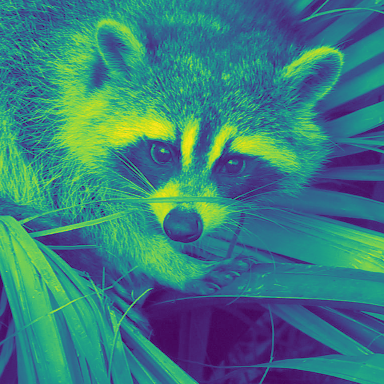

(384, 384) uint8 | total size: 0.0001373291015625 GiB


In [4]:
scene_image = misc.face(True).T[-769:-1:2, ::-2]
display_image(scene_image)
print_size(scene_image)

In [5]:
%%time
print('Sampling the light field signal...')

oversampled_signal = sample_2d_scene(scene_image, res_r, 3*res_a, 3*res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f)

print_size(oversampled_signal)

Sampling the light field signal...
(120, 120, 120, 120) uint8 | total size: 0.19311904907226562 GiB
Wall time: 756 ms


In [6]:
%%time
print('Downsampling the light field signal...')

downsampled_signal = decimate_lf(oversampled_signal, 3)

print_size(downsampled_signal)

Downsampling the light field signal...
(40, 40, 40, 40) uint8 | total size: 0.002384185791015625 GiB
Wall time: 0 ns


Computing retinal image from oversampled signal...


  0%|          | 0/147456 [00:00<?, ?it/s]

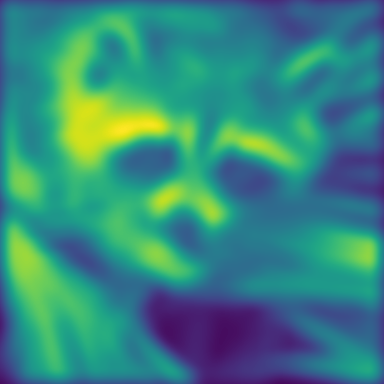

Wall time: 1h 12min 59s


In [7]:
%%time
print('Computing retinal image from oversampled signal...')

retinal_image = compute_retinal_image(oversampled_signal, res_r, 3*res_a, 3*res_b, size_r, size_a, size_b, 3, 3, z_r, z_a, z_b, z_f, pupil_diameter, square_aperture)

display_image(retinal_image)

Computing retinal image from downsampled signal...


  0%|          | 0/147456 [00:00<?, ?it/s]

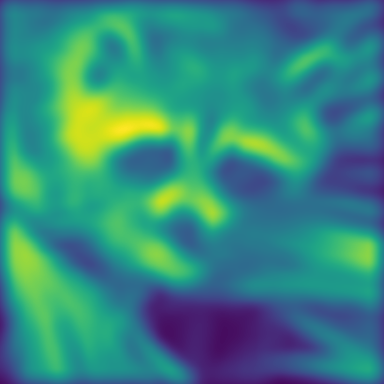

Wall time: 2min 20s


In [8]:
%%time
print('Computing retinal image from downsampled signal...')

retinal_image = compute_retinal_image(downsampled_signal, res_r, res_a, res_b, size_r, size_a, size_b, 1, 1, z_r, z_a, z_b, z_f, pupil_diameter, square_aperture)

display_image(retinal_image)